In [5]:
import os

adr_nbbo_dir = os.path.join('../data/raw/adrs/bbo-1m/nbbo')
adr_info_filename = os.path.join('..', 'data', 'raw', 'adr_info.csv')
futures_symbols_filename = os.path.join('../data/raw/futures_symbols.csv')
signal_dir = os.path.join('..', 'data', 'processed', 'futures_only_signal')
close_filename = os.path.join('..', 'data', 'raw', 'adrs', 'adr_PX_LAST_adjust_none.csv')
domestic_close_mid_filename = os.path.join('..', 'data', 'processed', 'adrs', 'adr_mid_at_ord_auction_adjust_none.csv')

In [6]:
import pandas as pd

close_df = pd.read_csv(close_filename, index_col=0, parse_dates=True)
dom_close_df = pd.read_csv(domestic_close_mid_filename, index_col=0, parse_dates=True)

In [7]:
measured_time = [
                '13:00:00',
                '13:30:00',
                '14:00:00',
                '14:30:00',
                '15:00:00',
                '15:30:00',
                '15:35:00',
                '15:40:00',
                '15:45:00',
            ]

In [8]:
import numpy as np

t0_for_cov  = '14:00:00'
all_daily = []
all_ic = {}
for ticker in close_df.columns:
    all_ic[ticker] = []
    for t0 in measured_time:
        df = pd.read_parquet(os.path.join(adr_nbbo_dir, f'ticker={ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
        df['mid'] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
        df['date'] = df.index.tz_localize(None).normalize()
        merged = df.merge(close_df[[ticker]].dropna().rename(columns={ticker: 'close'}), left_on='date', right_index=True)
        signal_df = pd.read_parquet(os.path.join(signal_dir, f'ticker={ticker}'), columns=['signal'])
        merged = signal_df.merge(merged, left_index=True, right_index=True)
        daily = merged.between_time(t0, t0).copy()
        daily['adr_ret'] = (daily['close'] - daily['mid']) / daily['mid']
        all_ic[ticker].append(daily['adr_ret'].corr(daily['signal']))
        if t0 == t0_for_cov:
            daily['ticker'] = ticker
            all_daily.append(daily[['ticker','adr_ret','signal']])
        
    print(f'Ticker: {ticker}, ICs: {np.mean(all_ic[ticker])}')

daily_df = pd.concat(all_daily)
daily_df['date'] = daily_df.index.tz_localize(None).normalize()
adr_ret_daily = daily_df.pivot(index='date', columns='ticker', values='adr_ret')
signal_daily = daily_df.pivot(index='date', columns='ticker', values='signal')

Ticker: BBVA, ICs: 0.14231813564877027
Ticker: VOD, ICs: 0.0732728982646471
Ticker: SNN, ICs: 0.056358165674427974
Ticker: NOK, ICs: 0.36781797049863485
Ticker: IHG, ICs: 0.0904509091228746
Ticker: WPP, ICs: 0.07692334777101216
Ticker: BP, ICs: 0.14468493178731553
Ticker: PHG, ICs: 0.05802931187400923
Ticker: AZN, ICs: -0.02283374901225661
Ticker: E, ICs: 0.03372431391598604
Ticker: SAN, ICs: 0.1934207488545102
Ticker: RTO, ICs: 0.036131055104572485
Ticker: SHEL, ICs: 0.04736167065243505
Ticker: ING, ICs: 0.1599594428210277
Ticker: BTI, ICs: 0.08452914271252175
Ticker: GSK, ICs: 0.07168646984633381
Ticker: SNY, ICs: 0.02257915226659817
Ticker: ARGX, ICs: 0.03035272884325159
Ticker: BCS, ICs: 0.11785422418707696
Ticker: RELX, ICs: 0.039330510375868225
Ticker: TTE, ICs: 0.08120317837445927
Ticker: SAP, ICs: 0.06418785621104232
Ticker: PSO, ICs: 0.09785539469149716
Ticker: DB, ICs: 0.1294602061204206
Ticker: HLN, ICs: 0.1171781170252284
Ticker: PUK, ICs: 0.11394983344351367
Ticker: TS, IC

In [ ]:
(adr_ret_daily - signal_daily).corr()

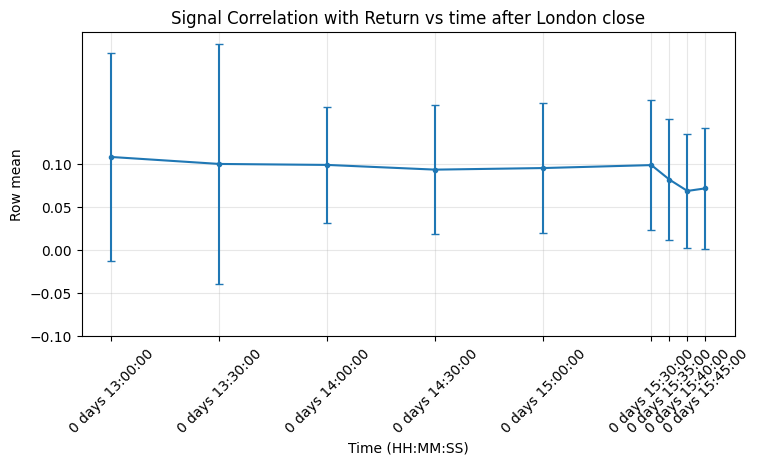

In [7]:
import seaborn as sns

df = pd.DataFrame(all_ic)
df.index = pd.to_timedelta(measured_time)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()


In [ ]:
all_sig = pd.read_parquet(os.path.join(signal_dir)).reset_index().pivot(index='index',
                                        columns='ticker',
                                        values='signal'
                                    )

In [ ]:
all_sig.loc['2025-05-01':].loc[:]

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BP,BTI,BUD,DB,...,SAN,SAP,SHEL,SNN,SNY,TS,TTE,UL,VOD,WPP
index,,,,,,,,,,,,,,,,,,,,,
2025-01-02 11:29:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:31:00-05:00,-0.002653,-0.001146,-0.000842,-0.000187,-0.001357,-0.001384,0.000450,0.000680,0.000496,0.000100,...,0.000914,0.000152,0.000303,-0.001390,0.000389,0.001245,0.002562,-0.001150,0.000589,-0.004306
2025-01-02 11:32:00-05:00,-0.003014,-0.001290,-0.000833,-0.000120,-0.001864,-0.000512,0.000538,0.001277,0.000970,0.000284,...,0.000420,0.000024,0.000537,0.000080,0.000329,0.001150,0.002448,-0.000928,0.000659,-0.003741
2025-01-02 11:33:00-05:00,-0.000430,-0.001116,0.000843,0.000624,-0.000604,0.001017,0.001712,0.001928,0.001230,0.001269,...,0.001646,0.000809,0.001705,0.000503,0.000425,0.001847,0.002911,-0.000498,0.001588,-0.002702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 15:55:00-05:00,-0.001744,0.009965,0.012944,-0.008647,-0.001413,0.002238,0.005086,-0.003295,-0.001065,0.002479,...,-0.000576,-0.003094,0.001358,-0.004730,0.003271,-0.001379,0.001712,-0.001476,0.003197,0.003628
2025-11-04 15:56:00-05:00,-0.001773,0.010538,0.013472,-0.008975,-0.000948,0.002759,0.005683,-0.003092,-0.000757,0.003559,...,0.000373,-0.003188,0.002060,-0.005110,0.004465,-0.001653,0.001940,-0.001297,0.003221,0.004223
2025-11-04 15:57:00-05:00,-0.001499,0.010896,0.015684,-0.008980,-0.001149,0.002914,0.005498,-0.003240,0.000018,0.004347,...,0.000741,-0.002984,0.002141,-0.005573,0.005628,-0.000682,0.002007,-0.001420,0.003291,0.003759


In [20]:
all_sig

,signal,ticker
2020-01-02 11:31:00-05:00,0.000417,AEG
2020-01-02 11:32:00-05:00,0.000405,AEG
2020-01-02 11:33:00-05:00,0.000369,AEG
2020-01-02 11:34:00-05:00,0.000000,AEG
2020-01-02 11:35:00-05:00,-0.000333,AEG
...,...,...
2025-11-04 15:55:00-05:00,0.003628,WPP
2025-11-04 15:56:00-05:00,0.004223,WPP
2025-11-04 15:57:00-05:00,0.003759,WPP
2025-11-04 15:58:00-05:00,0.003415,WPP


In [ ]:
import os
import pandas as pd